In [1]:
print("Hello")

Hello


in the tutorial they did: `pip3 install -U --user kuibit==1.5.0`

Careful with the installation of kuibit, in my case I created a conda env with python=3.12, installed numpy and matplotib, adn finally installed kuibit, all using pip

# Basic codes from the CactusTutorial

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
from kuibit.simdir import SimDir
import kuibit.visualize_matplotlib as viz

In [2]:
# datadir is the top-level directory that contains that data for
# a given simulation.

datadir='output-0000'

In [3]:
sim = SimDir(datadir)
# This will print a list with all the data available
print(sim)

Indexed 442 files and 3 subdirectories
Folder /home/jorge/Documents/ET_dir/output-0000
/home/jorge/Documents/ET_dir/output-0000
Available scalar timeseries:
[]

Available minimum timeseries:
['alp', 'vel[0]', 'vel[1]', 'vel[2]', 'H', 'dens', 'betax', 'betay', 'betaz', 'w_lorentz', 'M1', 'M2', 'M3', 'eps']

Available maximum timeseries:
['vel[0]', 'vel[1]', 'vel[2]', 'betax', 'betay', 'betaz', 'eps', 'M1', 'M2', 'M3', 'dens', 'H', 'alp', 'press', 'rho', 'w_lorentz']

Available norm1 timeseries:
['M1', 'M2', 'M3', 'H']

Available norm2 timeseries:
['M1', 'M2', 'M3', 'H']

Available average timeseries:
['physical_time_per_hour', 'current_physical_time_per_hour', 'time_total', 'time_evolution', 'time_computing', 'time_communicating', 'time_io', 'evolution_steps_count', 'local_grid_points_per_second', 'total_grid_points_per_second', 'local_grid_point_updates_count', 'total_grid_point_updates_count', 'local_interior_points_per_second', 'total_interior_points_per_second', 'local_interior_poin

Max difference 1.924e-18


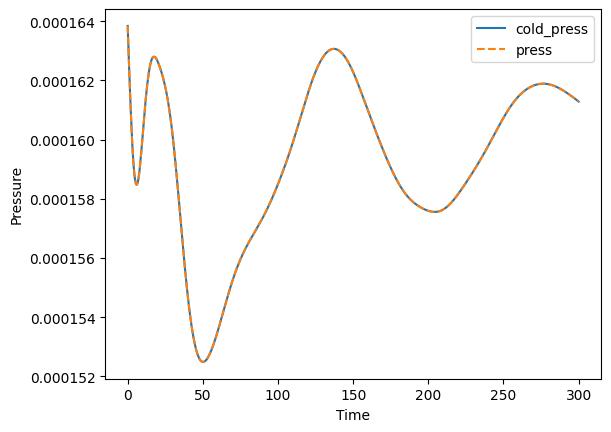

In [4]:
rho = sim.timeseries.maximum['rho']
press = sim.timeseries.maximum['press']

# Polytropic constants
K, Gamma = 100, 2

# Timeseries in kuibit support all the algebraic operations
cold_press = K * rho**Gamma

plt.ylabel("Pressure")
plt.xlabel("Time")
plt.plot(cold_press, label="cold_press")
plt.plot(press, label="press", ls="dashed")
plt.legend()

max_diff = abs(press - cold_press).max()

print(f"Max difference {max_diff:.3e}")

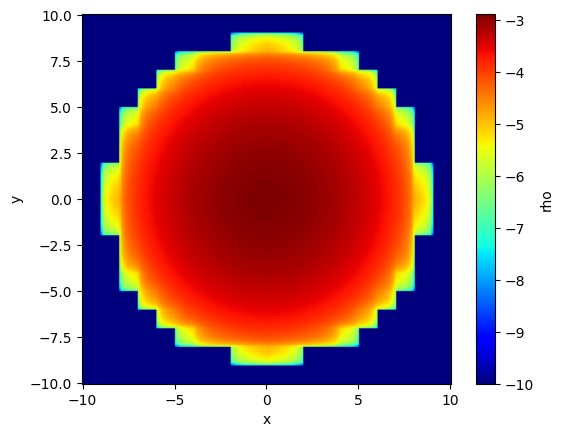

In [5]:
iteration_number = 0
rho_xy = sim.gridfunctions.xy["rho"][iteration_number]

# We cannot plot rho_xy directly because it contains all
# the information for the various refinement levels. 
# We need to resample the data onto a uniform grid.

# shape is the resolution at which we resample
# x0, x1 are the bottom left and top right coordiantes
# that we want to consider

# Here we choose x0=[0,0] because we have reflection 
# symmetry

# resample=True activates multilinear resampling

rho_xy_unif = rho_xy.to_UniformGridData(shape=[100, 100], 
                                        x0=[0,0],
                                        x1=[10, 10],
                                        resample=True)

# Undo reflection symmetry on the x axis
rho_xy_unif.reflection_symmetry_undo(dimension=0)
# Undo reflection symmetry on the y axis
rho_xy_unif.reflection_symmetry_undo(dimension=1)

viz.plot_color(rho_xy_unif,
               logscale=True,
               colorbar=True,
               cmap='jet',
               label="rho",
               xlabel="x",
               ylabel="y",
              )

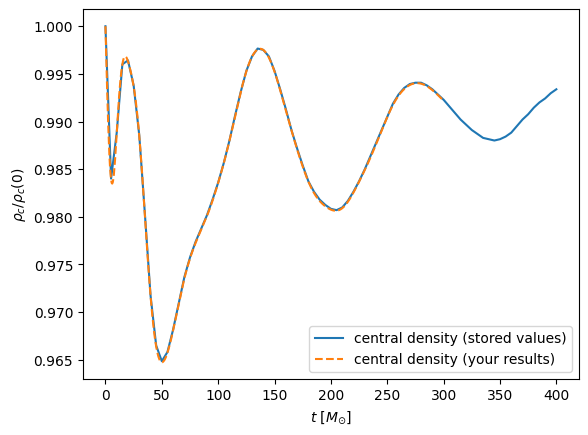

In [7]:
# this cell shows the expected plot using previously stored data
import numpy as np

# reconstruct plot data from saved strings
(quant_diff_s, minval, maxval, delta_t) = \
  ("ff8baee2e5d2ac70320c0007182c404f5b656f7b8897a8bbcddde8eeede8ddcfc0b0a29589817b777473757a8189929ca6b0bac4cbd0d3d4d4d2cfcbc7c2bdb8b4b0adaaa9a8a9abaeb3b8bcc1c5c8cccf",
   1.235e-03, 1.280e-03, 5.000e+00)
quant_diff = np.array(bytearray.fromhex(quant_diff_s))
rec_vals = quant_diff / 255. * (maxval- minval) + minval
rec_time = np.arange(0,len(quant_diff)) * delta_t

# plot them, including your results if you have them
plt.plot(rec_time, rec_vals/rec_vals[0],
         label="central density (stored values)")
try: plt.plot(rho/rho(0), label="central density (your results)", linestyle='--')
except: pass
plt.xlabel(r'$t$ [$M_{\odot}$]');
plt.ylabel(r'$\rho_c / \rho_c(0)$');
plt.legend(loc='lower right');

In [8]:
# create small dataset to show what plot should look like
def sparsify(lin_data, sparsity):
    # drop unwanted datapoint
    sparse_data = lin_data[::sparsity,:]
    
    # compute min, max of dataset then difference to minimum and quantize to 8 bit precisison
    minval = np.amin(sparse_data[:,2])
    maxval = np.amax(sparse_data[:,2])
    print("minval:",minval)
    print("maxval:",maxval)
    diff = sparse_data[:,2] - minval
    quant_diff = np.minimum(np.maximum(np.round(diff / (maxval - minval) * 255.5), 0), 255).astype('int')

    # timesteps are equidistant and start at 0 so we only need the stepsize
    delta_t = sparse_data[1,1] - sparse_data[0,1]

    # string rep of 8bit differences
    quant_diff_s = ""
    for i in quant_diff: quant_diff_s += "%02x" % i
    
    print ('"%s", %.3e, %.3e, %.3e' % (quant_diff_s, minval, maxval, delta_t))

# create a low fidelity representation of every 10th datapoint and output all data a string
sparsify(np.array([rho.t,rho.x,rho.y]).transpose(), 10)

minval: 0.00123486424895186
maxval: 0.00127999999244924
"ff8baee2e5d2ac70320c0007182c404f5b656f7b8897a8bbcddde8eeede8ddcfc0b0a29589817b777473757a8189929ca6b0bac4cbd0d3d4d4d2cfcbc7", 1.235e-03, 1.280e-03, 5.000e+00


# Kuibit Series - 0

In [ ]:
# Follow the youtube series, maybe

# Kuibit Series - 4 - General Structure

Practical tip: work with objects

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from kuibit.simdir import SimDir
from kuibit.timeseries import TimeSeries

In [46]:
sim = SimDir("/home/jorge/Escritorio/Lic. Física/1Ramos/1Semestre X/Tesina/Toolkit/Simulations/testPert16/output-0000/")

gridfunctions organizes the data depending on the dimension

In [48]:
gf = sim.gf         # gf the same as gridfunctions, alias
print(gf), print(type(gf))


Available grid data of dimension 1D (x): 
[]


Available grid data of dimension 1D (y): 
[]


Available grid data of dimension 1D (z): 
[]


Available grid data of dimension 2D (xy): 
[]


Available grid data of dimension 2D (xz): 
[]


Available grid data of dimension 2D (yz): 
[]


Available grid data of dimension 3D (xyz): 
['gxx', 'gxy', 'gxz', 'gyy', 'gyz', 'gzz', 'rho', 'kxx', 'kxy', 'kxz', 'kyy', 'kyz', 'kzz', 'grid_coordinates', 'grid_structure']

<class 'kuibit.cactus_grid_functions.GridFunctionsDir'>


(None, None)

`GridFunctionsDir` means that this are grid functions that come from `SimDir`

# Kuibit Series - 5 - Timeseries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from kuibit.simdir import SimDir
from kuibit.timeseries import TimeSeries

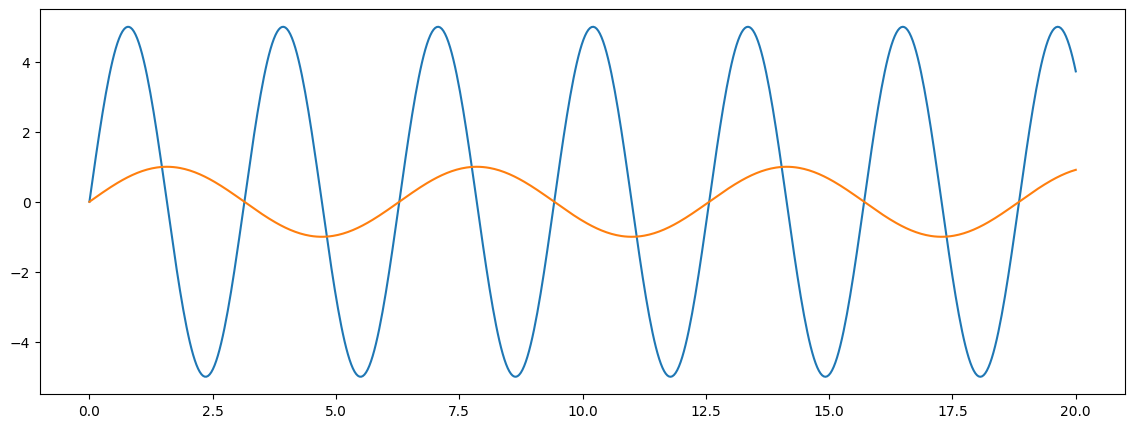

In [39]:
t = np.linspace(0,20,600)
y1, y2 = np.sin(t), np.cos(t)

ts1 = TimeSeries(t, y1)
ts2 = TimeSeries(t, y2)

plt.figure(figsize=(14,5))
plt.plot(ts1 * ts2 * 10)
plt.plot(ts1)

We have tons of methods for TimeSeries

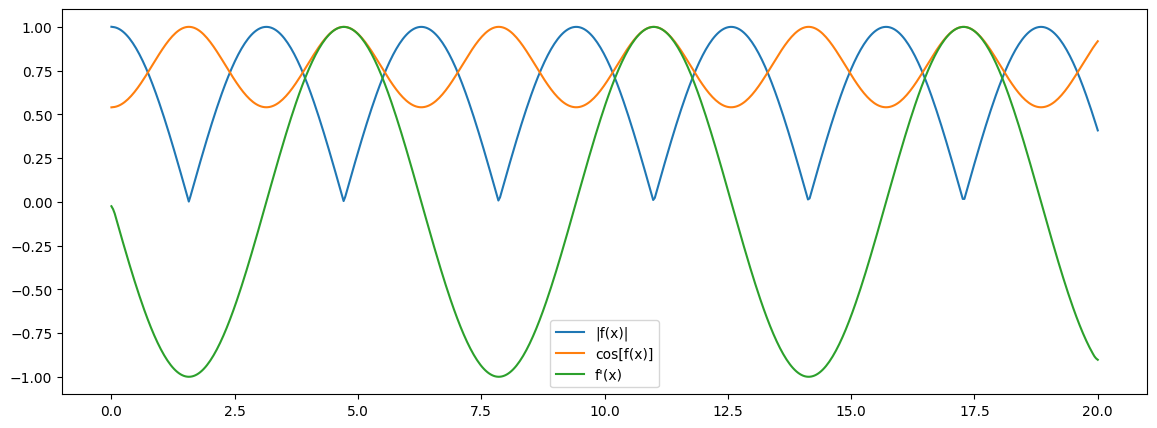

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(ts1.abs(), label='|f(x)|')
plt.plot(ts1.cos(), label="cos[f(x)]")
plt.plot(ts1.differentiated(), label="f'(x)")

plt.legend()

Notice how we use the imperative form `differentiate()` to modify the object, and the past tense `differentiated()` to return a new object

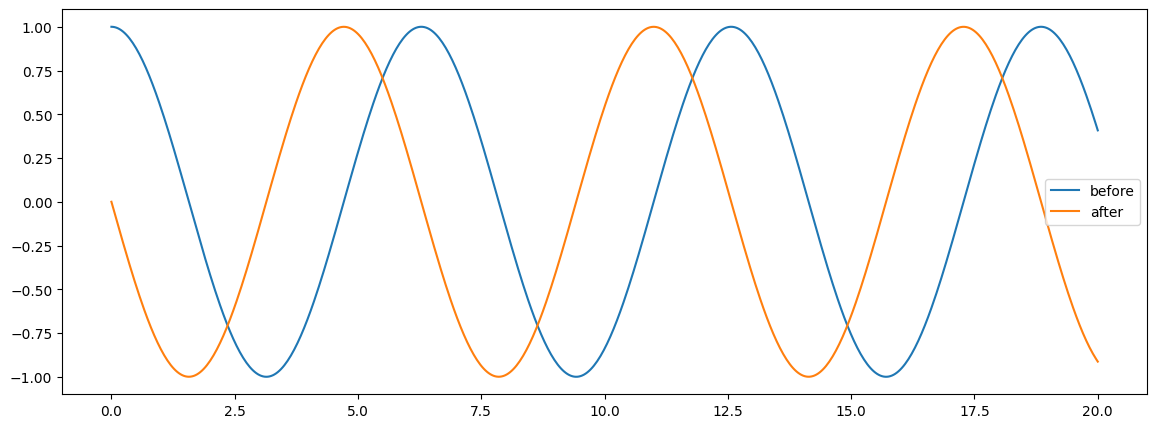

In [40]:
plt.figure(figsize=(14,5))
plt.plot(ts2, label="before")
ts2.differentiate()         #This modifies ts2
plt.plot(ts2, label="after")

plt.legend()

Note that if u run the previous cell a bunch of times, numerical errors in the differentiation scheme completely destroy the original `cos()` which should remain bouncing between `cos()` and `sin()`

We can use TimeSeries as analytical functions in that we can evaluate the TimeSeries anywhere within the domain, i.e. continously. This is done with cubic splines 

In [43]:
ts1(np.pi), ts1(np.sqrt(2))

(1.9417969216204778e-11, 0.9877659433014421)

# Tutorial from ET workshop

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from kuibit.simdir import SimDir
from kuibit.timeseries import TimeSeries

More useful methods: `derive`, `integrate`, `band_pass`, `crop`, `smooth`, `window`, `resample`, `redshift`

In [ ]:
sim = SimDir("/home/jorge/Downloads/FromDocker/testPert16/output-0000")         # MSI path

# Real data from one of Robyn's simulations

In [9]:
# Use et2 for compatibility
from kuibit.simdir import SimDir
import kuibit.visualize_matplotlib as viz
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Point to the folder containing all your ET outputs
#sim = SimDir("~/Downloads/FromDocker/testPert/output-0000/testPert")  
sim = SimDir("/home/jorge/Escritorio/Lic. Física/1Ramos/1Semestre X/Tesina/Toolkit/Simulations/testPert16/output-0000/")

In [4]:
print(sim)

Indexed 19 files and 2 subdirectories
Folder /home/jorge/Escritorio/Lic. Física/1Ramos/1Semestre X/Tesina/Toolkit/Simulations/testPert16/output-0000
/home/jorge/Escritorio/Lic. Física/1Ramos/1Semestre X/Tesina/Toolkit/Simulations/testPert16/output-0000
Available scalar timeseries:
[]

Available minimum timeseries:
[]

Available maximum timeseries:
[]

Available norm1 timeseries:
[]

Available norm2 timeseries:
[]

Available average timeseries:
['betax', 'betay', 'betaz', 'kxx', 'kxy', 'kxz', 'kyy', 'kyz', 'kzz', 'H', 'rho', 'gxx', 'gxy', 'gxz', 'gyy', 'gyz', 'gzz', 'M1', 'M2', 'M3', 'alp']
Variables available: dict_keys([])

Available grid data of dimension 1D (x): 
[]


Available grid data of dimension 1D (y): 
[]


Available grid data of dimension 1D (z): 
[]


Available grid data of dimension 2D (xy): 
[]


Available grid data of dimension 2D (xz): 
[]


Available grid data of dimension 2D (yz): 
[]


Available grid data of dimension 3D (xyz): 
['gxx', 'gxy', 'gxz', 'gyy', 'gyz', 'g

Are these all the necessary varialbles or do we have to calculate (or request) others?

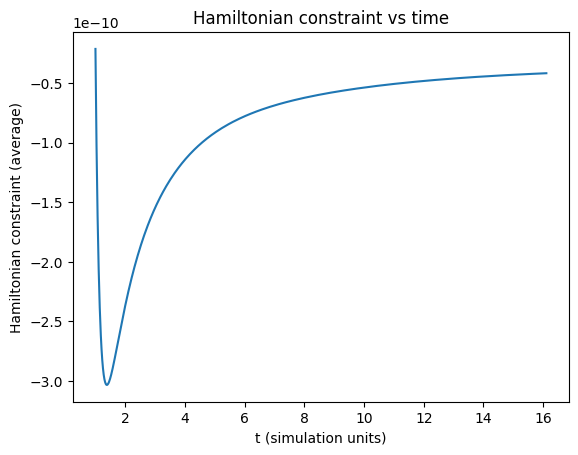

In [ ]:
ham = sim.timeseries.average['H']  
plt.plot(ham.t, ham.y)
plt.xlabel("t (simulation units)")
plt.ylabel("Hamiltonian constraint (average)")          # Not sure about the labels
plt.title("Hamiltonian constraint vs time")
plt.show()

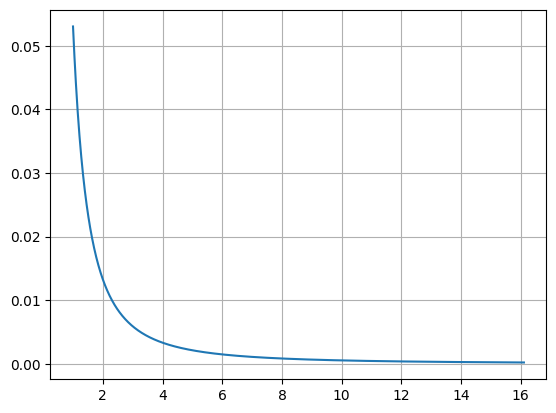

In [6]:
rho = sim.timeseries.average['rho']     
plt.plot(rho.t, rho.y)
plt.grid()

`rho` decae bastante rápido. En la horizontal no tenemos iteraciones, qué parámetro es?

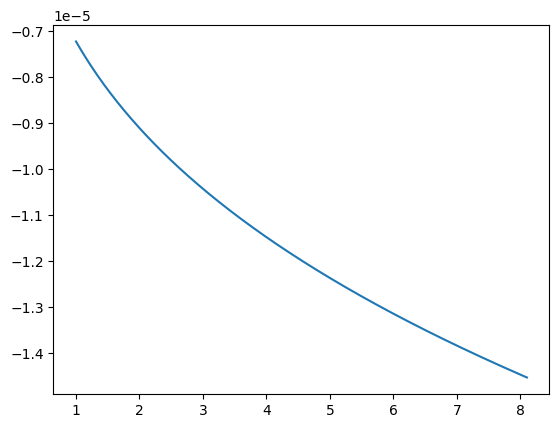

In [7]:
kxx = sim.timeseries.average['kxx']  
plt.plot(kxx.t, kxx.y)

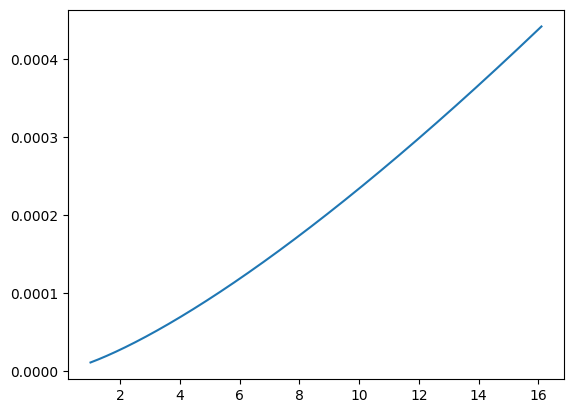

In [ ]:
gxx = sim.timeseries.average['gxx']         # spatial metric xx component
plt.plot(gxx.t, gxx.y)

# Redshift and Scale factor

$$1+z=\frac{1}{a}$$

In [10]:
np.sqrt(gxx.y[0])       # LCDM: z = 302.5, a = 0.00329
                        # CT_Dust::Lambda = 1.0382472680261657e-07

0.0032945241410744135

In [ ]:
# redshift inicial para la simulación testPert16
1/np.sqrt(gxx.y[0]) -1

302.53397248862746

Q: esta fórmula es válida solamente cuando las perturbaciones son despreciables, i.e., al inicio de la simulación? De ser así, necesito otra forma de calcular $a/a_{IN}$

In [ ]:
# redshift final para la simulación testPert16    
1/np.sqrt(gxx.y[-1]) - 1

46.58958237662406

In [82]:
np.sqrt(gxx.y[-1])  

0.021013002217291965

In [ ]:
np.sqrt(gxx.y[-1]) / np.sqrt(gxx.y[0])              #a_end / a_in

6.378160036926967

# 3D Grid data 

In [3]:
sim.allfiles

['/home/jorge/Escritorio/Lic. Física/1Ramos/1Semestre X/Tesina/Toolkit/Simulations/testPert16/output-0000/test.par',
 '/home/jorge/Escritorio/Lic. Física/1Ramos/1Semestre X/Tesina/Toolkit/Simulations/testPert16/output-0000/testPert16.out',
 '/home/jorge/Escritorio/Lic. Física/1Ramos/1Semestre X/Tesina/Toolkit/Simulations/testPert16/output-0000/testPert16.err',
 '/home/jorge/Escritorio/Lic. Física/1Ramos/1Semestre X/Tesina/Toolkit/Simulations/testPert16/output-0000/test/admbase-shift.average.asc',
 '/home/jorge/Escritorio/Lic. Física/1Ramos/1Semestre X/Tesina/Toolkit/Simulations/testPert16/output-0000/test/grid_coordinates.asc',
 '/home/jorge/Escritorio/Lic. Física/1Ramos/1Semestre X/Tesina/Toolkit/Simulations/testPert16/output-0000/test/admbase-metric.file_1.h5',
 '/home/jorge/Escritorio/Lic. Física/1Ramos/1Semestre X/Tesina/Toolkit/Simulations/testPert16/output-0000/test/admbase-curv.average.asc',
 '/home/jorge/Escritorio/Lic. Física/1Ramos/1Semestre X/Tesina/Toolkit/Simulations/testP

In [38]:
sim.gridfunctions.__doc__

'This class provides access to all grid data.\n\n    This includes 1D-3D data in HDF5 and ASCII formats. Data of the required\n    dimensionality is read from any format available (HDF5 preferred over\n    ASCII). If you need lower dimensional data, read the higher dimensional one\n    and slice the data.\n\n    :ivar x:           Access to 1D data along x-axis.\n    :ivar y:           Access to 1D data along y-axis.\n    :ivar z:           Access to 1D data along z-axis.\n    :ivar xy:          Access to 2D data along xy-plane.\n    :ivar xz:          Access to 2D data along xz-plane.\n    :ivar yz:          Access to 2D data along yz-plane.\n    :ivar xyz:         Access to 3D data.\n\n    '

In [42]:
sim.gridfunctions._dim_indices['xyz']

(0, 1, 2)

In [8]:
xyz_dims = sim.gf.xyz
type(xyz_dims)

kuibit.cactus_grid_functions.AllGridFunctions

In [14]:
sim.gf.xyz['rho'], sim.gf.xyz['rho'][0], sim.gf.xyz['rho'][0][0], sim.gf.xyz['rho'][0][0][0][0]

(<kuibit.cactus_grid_functions.OneGridFunctionH5 at 0x7fbef9f5a720>,
 array([[0.05305164, 0.05305247, 0.05305327, ..., 0.05304929, 0.05305002,
         0.05305082],
        [0.05305247, 0.0530533 , 0.05305409, ..., 0.05305012, 0.05305085,
         0.05305164],
        [0.05305327, 0.05305409, 0.05305489, ..., 0.05305091, 0.05305165,
         0.05305244],
        ...,
        [0.05304929, 0.05305012, 0.05305091, ..., 0.05304693, 0.05304767,
         0.05304846],
        [0.05305002, 0.05305085, 0.05305165, ..., 0.05304767, 0.0530484 ,
         0.0530492 ],
        [0.05305082, 0.05305164, 0.05305244, ..., 0.05304846, 0.0530492 ,
         0.05304999]]))

In [ ]:
res, xmax = 64, 320 

# resample to uniform grid data?
rho = sim.gf.xyz['rho'][0][0]

In [16]:
sim.gf.xyz['rho'][0][0][0]

In [5]:
type(sim.gf.xyz['rho'][0]), type(sim.gf.xyz['rho'][0][0])

(kuibit.grid_data.HierarchicalGridData, list)

In [ ]:
rho[0][31]

IndexError: index 32 is out of bounds for axis 0 with size 32

In [25]:
rho[0][0][2]

array([0.05305327, 0.05305409, 0.05305489, 0.05305562, 0.05305627,
       0.05305679, 0.05305719, 0.05305743, 0.05305751, 0.05305743,
       0.05305719, 0.05305679, 0.05305627, 0.05305562, 0.05305489,
       0.05305409, 0.05305327, 0.05305244, 0.05305165, 0.05305091,
       0.05305027, 0.05304974, 0.05304935, 0.05304911, 0.05304903,
       0.05304911, 0.05304935, 0.05304974, 0.05305027, 0.05305091,
       0.05305165, 0.05305244])

In [21]:
rho_ug = sim.gf.xyz['rho'][1]       # extraño, es como si solo tuviera una iteración

KeyError: 'Iteration 1 not present'

In [20]:
rho_ug[0][0][31].shape            # rho_ug[0][0][i] from i=0 to i=31

(32, 32)

`rho_ug[0][0]` tiene la data de las 3 dimensiones, pero creo que una sola iteración

In [67]:
rho_ug[0][0][31]

array([[0.05305082, 0.05305164, 0.05305244, ..., 0.05304846, 0.0530492 ,
        0.05304999],
       [0.05305164, 0.05305247, 0.05305327, ..., 0.05304929, 0.05305002,
        0.05305082],
       [0.05305244, 0.05305327, 0.05305406, ..., 0.05305009, 0.05305082,
        0.05305161],
       ...,
       [0.05304846, 0.05304929, 0.05305009, ..., 0.05304611, 0.05304684,
        0.05304764],
       [0.0530492 , 0.05305002, 0.05305082, ..., 0.05304684, 0.05304757,
        0.05304837],
       [0.05304999, 0.05305082, 0.05305161, ..., 0.05304764, 0.05304837,
        0.05304916]])

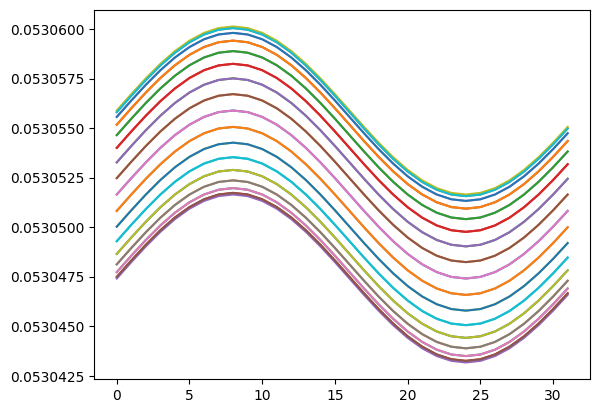

In [ ]:
plt.plot(rho_ug[0][0][0])

In [61]:
rho_ug[0][0]

In [ ]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

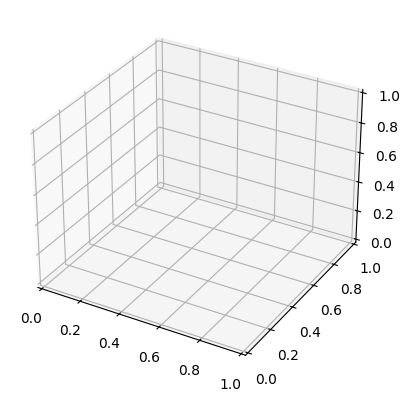

In [17]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

In [ ]:
# 3d plot

#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')
#ax.plot_surface(X, Y, Z, cmap='viridis')

In [18]:
import numpy as np
import matplotlib.pyplot as plt

arr = rho_ug[0][0]
nx, ny, nz = arr.shape

# Take a slice at z = middle
#z_index = nz // 2
z_index = 31
slice_xy = arr[:, :, z_index]

plt.imshow(slice_xy.T, origin="lower", cmap="jet")
plt.colorbar(label="value")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Slice at z={z_index}")
plt.show()


NameError: name 'rho_ug' is not defined

In [17]:
z_index = 0
slice_xy = arr[:, :, z_index]

plt.imshow(slice_xy.T, origin="lower", cmap="jet")
plt.colorbar(label="value")
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"Slice at z={z_index}")
plt.show()

NameError: name 'arr' is not defined

Luego hacer una animación desde z=0 hasta z=31

In [ ]:
# Not quite 

import numpy as np

iteration_number = 0
rho = sim.gridfunctions.xyz["rho"][iteration_number]
#coords = sim.gridfunctions.xyz["grid_coordinates"][0]

#x, y, z = coords  # arrays of grid points
x = np.arange(-320, 320, 20)
y = np.arange(-320, 320, 20)
z = np.arange(-320, 320, 20)

# Let's take a slice at z=0 (find the index closest to 0)
z_index = np.argmin(np.abs(z))
rho_slice = rho[:, :, z_index]

plt.imshow(rho_slice.T, origin="lower", extent=[x.min(), x.max(), y.min(), y.max()])
plt.colorbar(label="rho")
plt.xlabel("x")
plt.ylabel("y")
plt.title("ρ slice at z=0")
plt.show()

KeyError: (slice(None, None, None), slice(None, None, None), 16)